In [1]:
%matplotlib inline

# Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)

Authors: Martin Billinger

Decoding of motor imagery applied to EEG data decomposed using CSP.
Here the classifier is applied to features extracted on CSP filtered signals.

See http://en.wikipedia.org/wiki/Common_spatial_pattern and [1]

The EEGBCI dataset is documented in [2]
The data set is available at PhysioNet [3]

[1] Zoltan J. Koles. The quantitative extraction and topographic mapping
    of the abnormal components in the clinical EEG. Electroencephalography
    and Clinical Neurophysiology, 79(6):440--447, December 1991.

[2] Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N.,
    Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface
    (BCI) System. IEEE TBME 51(6):1034-1043

[3] Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG,
    Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank,
    PhysioToolkit, and PhysioNet: Components of a New Research Resource for
    Complex Physiologic Signals. Circulation 101(23):e215-e220



In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [3]:
# Set parameters and read data

# avoid classification of evoked responses by using epochs that
# start 1s after cue onset.
tmin, tmax = -1., 4.
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw_fnames

['/Users/rodin/BRU/mne-python/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf',
 '/Users/rodin/BRU/mne-python/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf',
 '/Users/rodin/BRU/mne-python/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf']

In [4]:
raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raw_files)

In [5]:
raw

<RawEDF  |  S001R06.edf, n_channels x n_times : 64 x 60000 (375.0 sec), ~29.4 MB, data loaded>

In [6]:
raw.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 80.0 Hz
    meas_date : tuple | 2009-08-12 16:15:00 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter

In [7]:
raw.annotations

<Annotations  |  94 segments : T0 (45), T2 (24), T1 (21)..., orig_time : 2009-08-12 16:15:00>

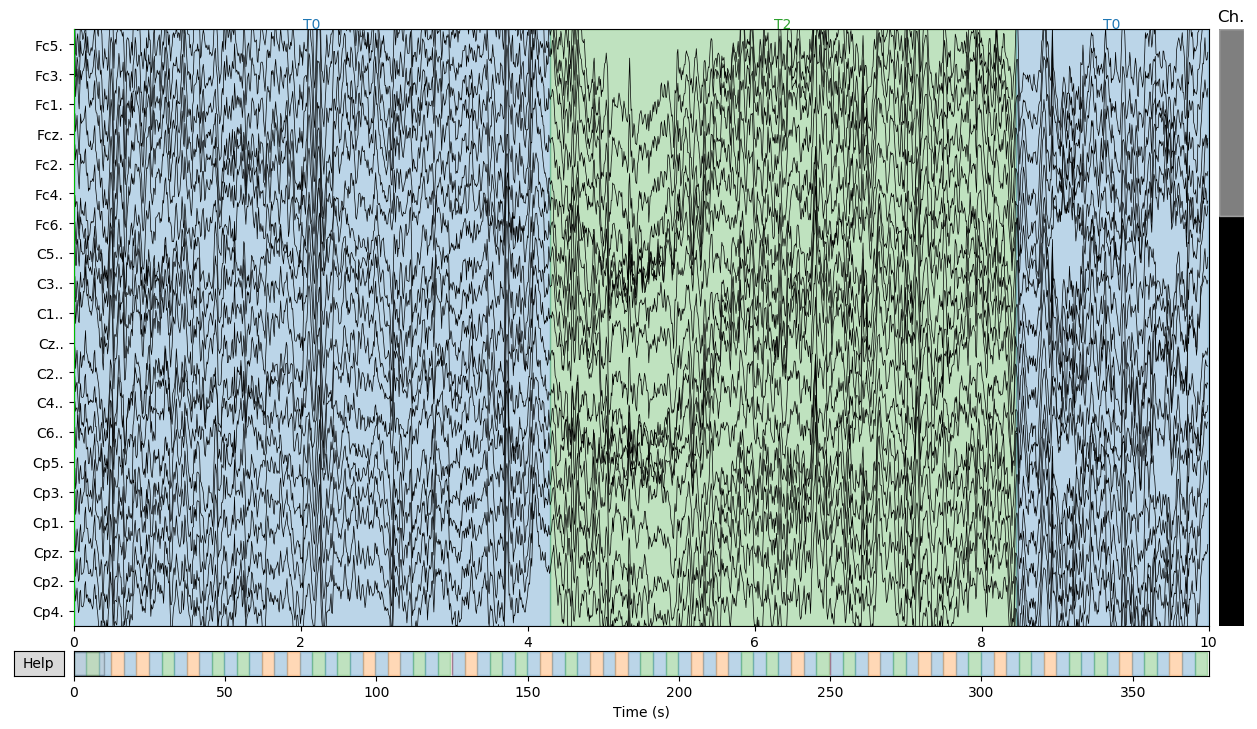

In [8]:
%matplotlib qt
raw.plot()

In [9]:
%matplotlib inline
# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

In [10]:
raw.ch_names

['Fc5',
 'Fc3',
 'Fc1',
 'Fcz',
 'Fc2',
 'Fc4',
 'Fc6',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'Cp5',
 'Cp3',
 'Cp1',
 'Cpz',
 'Cp2',
 'Cp4',
 'Cp6',
 'Fp1',
 'Fpz',
 'Fp2',
 'Af7',
 'Af3',
 'Afz',
 'Af4',
 'Af8',
 'F7',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'Ft7',
 'Ft8',
 'T7',
 'T8',
 'T9',
 'T10',
 'Tp7',
 'Tp8',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'Po7',
 'Po3',
 'Poz',
 'Po4',
 'Po8',
 'O1',
 'Oz',
 'O2',
 'Iz']

In [11]:
# Apply band-pass filter
raw.filter(7., 30., method='iir')

# events = find_events(raw, shortest_event=0, stim_channel='STI 014', verbose=True)
events, _ = mne.events_from_annotations(raw)

In [12]:
events[:10]

array([[   0,    0,    1],
       [ 672,    0,    2],
       [1328,    0,    1],
       [2000,    0,    3],
       [2656,    0,    1],
       [3328,    0,    3],
       [3984,    0,    1],
       [4656,    0,    2],
       [5312,    0,    1],
       [5984,    0,    3]])

In [13]:
event_id = dict(hands=2, feet=3)

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

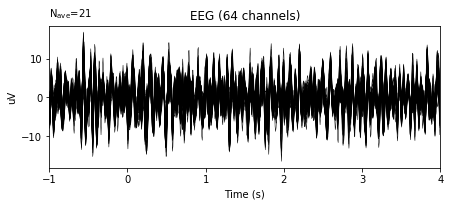

In [14]:
epochs['feet'].average().plot();

Classification with linear discrimant analysis



In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True)

In [16]:
epochs.get_data().shape

(45, 64, 801)

In [17]:
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = []
X = epochs.get_data()
X_train = epochs_train.get_data()

In [18]:
# Use scikit-learn Pipeline with cross_val_score function
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
clf = Pipeline([('CSP', csp), ('LDA', lda)])

In [19]:
clf

Pipeline(memory=None,
         steps=[('CSP',
                 CSP(cov_est='concat', cov_method_params=None, log=True, n_components=4,
  norm_trace=False, rank=None, reg=None, transform_into='average_power')),
                ('LDA',
                 LinearDiscriminantAnalysis(n_components=None, priors=None,
                                            shrinkage=None, solver='svd',
                                            store_covariance=False,
                                            tol=0.0001))])

In [20]:
scores = cross_val_score(clf, X_train, labels, cv=cv, n_jobs=1)
print(scores)

[0.88888889 0.88888889 1.         1.         1.         0.88888889
 0.88888889 1.         1.         0.88888889]


Classification accuracy: 0.944444 / Chance level: 0.533333


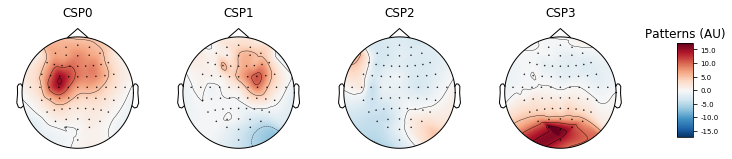

In [21]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(X, labels)

import mne
info = epochs.average().info.copy()
info['sfreq'] = 1
evoked = mne.EvokedArray(csp.patterns_.T, info, tmin=0)

layout = read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5);

## Look at performance over time

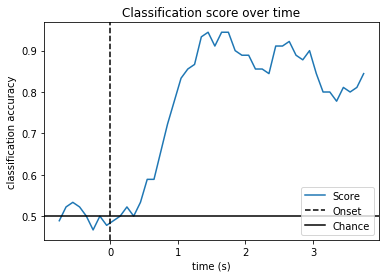

In [22]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, X.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv.split(X, labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    XX_train = csp.fit_transform(X_train[train_idx], y_train)
    XX_test = csp.transform(X_train[test_idx])

    # fit classifier
    lda.fit(XX_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        XX_test = csp.transform(X[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(XX_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()